In [2]:
import copy
from pathlib import Path
import warnings
import pickle
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pymysql
import pytorch_lightning

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\danie\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
# Loads the data from the external database
user_threshold = 0
dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
data = pd.read_sql("select * from summary order by timestamp desc limit 2000", dbcon) # Can remove/increase limit if enough GPU memory for CUDA, will increase accuracy
data.fillna(value = 0, inplace = True) # Replaces NoneType values with 0
data.replace(1.1e308, 0, inplace = True) # Replaces infinite values with 0
data = data[::-1]
data.reset_index(inplace=True, drop=True)

In [4]:
# Normalizes the data for use in the encoder
ts_data = pd.DataFrame()
cols = data.columns[1:]
sensor = []
timestamp = []
value = []
time_idx = []
ti = 0
for i in range(len(data["timestamp"])):
    for j in cols:
        timestamp.append(data["timestamp"][i])
        value.append(data[j][i])
        sensor.append(j)
        time_idx.append(ti)
    ti += 1
ts_data["timestamp"] = timestamp
ts_data["sensor"] = sensor
ts_data["value"] = value
ts_data["time_idx"] = time_idx
id = []
for i in range(len(ts_data)):
    id.append(i)
ts_data["id"] = id
# ts_data has 4 columns, timestamp, sensor, value, and time_idx
# There is a value for each sensor for each timestamp

# The below optionally removes all sensors which are inactive. This is reccomended to stop overfitting to inactive sensors which causes the predictions to ignore active ones
# If this is commented out, most predictions will lie at 0 as most sensors have an average value of 0 due to being inactive. Only comment this out if the majority of sensors are active
tmp = ts_data[ts_data["value"] != 0]
active_sensors = set(tmp["sensor"])
ts_data = ts_data[ts_data["sensor"].isin(active_sensors)]

In [ ]:
# Sets up the initial parameters
max_prediction_length = int(len(ts_data)*0.4) # 60% training, 40% testing. Feel free to change this ratio if results are not as expected
max_encoder_length = 16
training_cutoff = ts_data["id"].max() - max_prediction_length

In [ ]:
training = TimeSeriesDataSet(
    ts_data[lambda x: x.id <= training_cutoff], # Lambda function to select all data before the cutoff
    time_idx="time_idx",
    target="value",
    group_ids=["sensor"], # Required to identify rows uniquely
    min_encoder_length=max_encoder_length//2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    add_relative_time_idx=True,
    static_categoricals=["sensor"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"],
    allow_missing_timesteps=False # Set to False as time_idx increases steadily, if this function is edited and time_idx no longer increases steadily must be set to True
)

In [ ]:
validation = TimeSeriesDataSet(
    ts_data[lambda x: x.id > training_cutoff], # Lambda function to select all data before the cutoff
    time_idx="time_idx",
    target="value",
    group_ids=["sensor"], # Required to identify rows uniquely
    min_encoder_length=max_encoder_length//2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    predict_mode=True,
    add_relative_time_idx=True,
    static_categoricals=["sensor"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"],
    allow_missing_timesteps=False # Set to False as time_idx increases steadily, if this function is edited and time_idx no longer increases steadily must be set to True
)

In [ ]:
# Creates dataloaders for the model
batch_size = 8  # higher values increase accuracy at cost of CUDA memory
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0) # Num_workers can be increased on multi-core machines
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# Calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

In [ ]:
# Configures the network and trainer for getting hyperparameter values
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=torch.cuda.device_count(), # Set to the amount of GPU's you want to use
    gradient_clip_val=0.1,
)

In [ ]:
# Creates the sample prediction function
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16, 
    attention_head_size=1, # Can be increased up to 4 for larger datasets
    dropout=0.1,  # Between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # Set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4, # Reduce learning rate if no improvement in validation loss after x epoch
)
#print(f"Number of parameters in network: {tft.size()/1e3:.1f}k") Uncomment to show number of parameters

In [ ]:
# Find the optimal learning rate
torch.cuda.empty_cache()
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)
#print(f"suggested learning rate: {res.suggestion()}") Uncomment to show learning rate
# Plots learning rate to show optimal value
#fig = res.plot(show=True, suggest=True) Uncomment to plot learning rate

In [ ]:
# Loads best study (see below)
try:
    with open("test_study.pkl", "rb") as fout:
        study = pickle.load(fout)
    keys = []
    values = []
    for i in study.best_trial.params.keys():
        keys.append(i)
    for i in study.best_trial.params.values():
        values.append(i)
except:
    print("Run the Optimizse Hyperparameters Cell")

In [ ]:
# Configures the network and trainer
torch.cuda.empty_cache()
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
try:
    trainer = pl.Trainer(
        max_epochs=30,
        gpus=1,
        weights_summary="top",
        gradient_clip_val=values[keys.index("gradient_clip_val")],
        limit_train_batches=30,  # comment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )
except:
    trainer = pl.Trainer(
        max_epochs=30,
        gpus=1,
        weights_summary="top",
        gradient_clip_val=0.1,
        limit_train_batches=30,  # comment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )

In [ ]:
# Creates the prediction function
torch.cuda.empty_cache()
try:
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=values[keys.index("learning_rate")],
        hidden_size=values[keys.index("hidden_size")],
        attention_head_size=values[keys.index("attention_head_size")],
        dropout=values[keys.index("dropout")],
        hidden_continuous_size=values[keys.index("hidden_continuous_size")],
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
except:
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.1,
        hidden_size=8,
        attention_head_size=3,
        dropout=0.25,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
#print(f"Number of parameters in network: {tft.size()/1e3:.1f}k") Uncomment to show number of parameters

In [ ]:
# Fits the network
torch.cuda.empty_cache()
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# Create a study of optimized hyperparameters - Check optuna_test folder for trial logs per epoch
# This takes a large amount of time to run so it is only really useful when re-training the model from scratch (can be 1 hour+ to fully optimize)
torch.cuda.empty_cache()
study = optimize_hyperparameters(
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    model_path="optuna_test",
    n_trials=200, #This can be increased to increase accuracy at the cost of execution speed
    max_epochs=30, # This can be increased to increase accuracy at the cost of execution speed
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

In [ ]:
# Save study results so we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

In [ ]:
# Show best hyperparameters
study.best_trial.params

In [ ]:
# Load the best model according to the validation loss (given that we use early stopping, this is not necessarily the last epoch)
torch.cuda.empty_cache()
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
with open("ts_model.pkl", "wb") as fout:
    pickle.dump(best_tft, fout)

In [ ]:
# Calcualtes the mean absolute error on validation set
torch.cuda.empty_cache()
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
#(actuals - predictions).abs().mean()

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_forecasting\data\timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


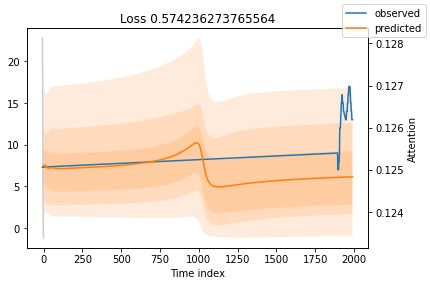

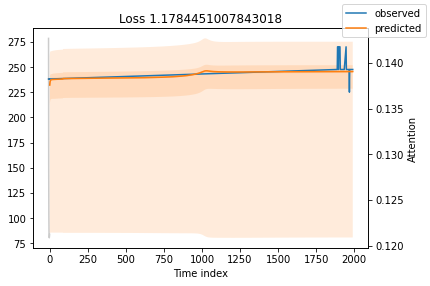

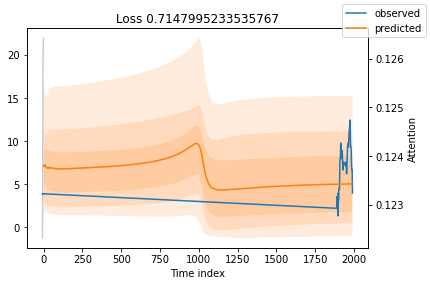

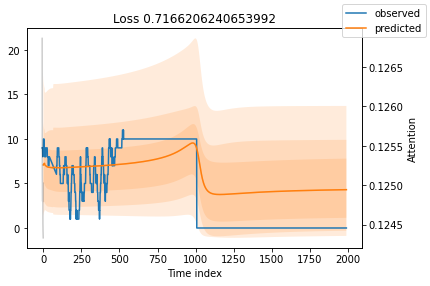

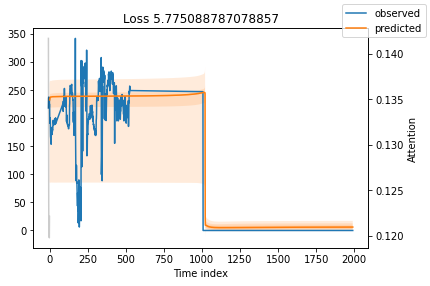

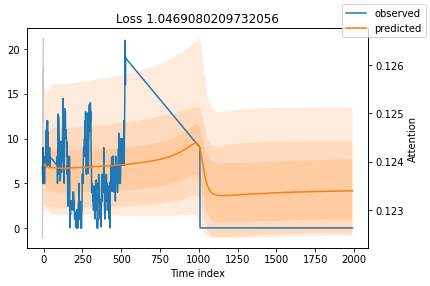

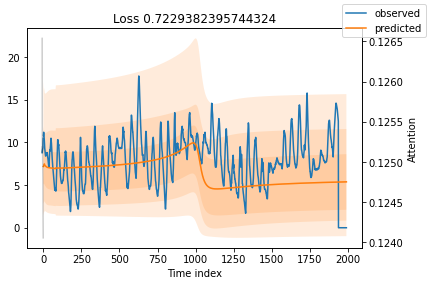

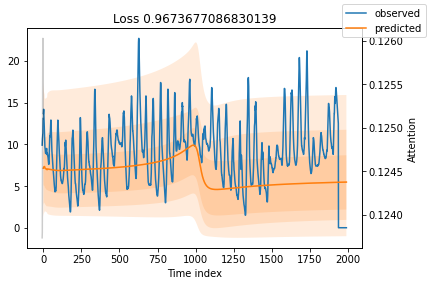

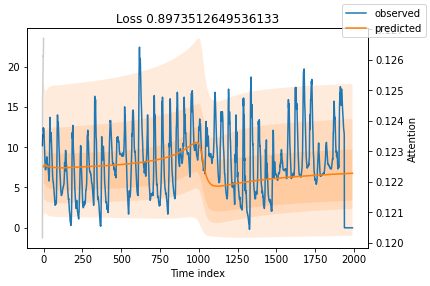

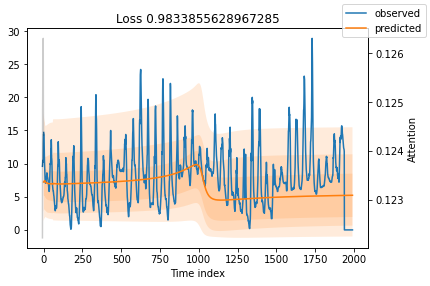

In [4]:
# This is the only time series function that needs to be ran if you don't want to update the training
# Creates the data set to run the prediction on using all the most recent data from the external database
# Sets up the initial parameters
max_prediction_length = int(len(ts_data)*0.4) # 60% training, 40% testing. Feel free to change this ratio if results are not as expected
max_encoder_length = 16
training_cutoff = ts_data["id"].max() - max_prediction_length
validation = TimeSeriesDataSet(
    ts_data, # No lambda function to select all data
    time_idx="time_idx",
    target="value",
    group_ids=["sensor"], # Required to identify rows uniquely
    min_encoder_length=max_encoder_length//2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    predict_mode=True,
    add_relative_time_idx=True,
    static_categoricals=["sensor"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"],
    allow_missing_timesteps=False # Set to False as time_idx increases steadily, if this function is edited and time_idx no longer increases steadily must be set to True
)
# Creates all neccesary functions with the new dataset and best prediction model
batch_size = 8  # higher values increase accuracy at cost of CUDA memory
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
torch.cuda.empty_cache()

# Opens the saved prediction model
try:
    with open("ts_model.pkl", "rb") as fout:
        best_tft = pickle.load(fout)
except:
    print("No model found")

# Raw predictions here are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

#Prints the graphs of predictions vs actual values
for idx in range(len(active_sensors)):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'time_idx': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'value': <Figure size 720x360 with 2 Axes>,
 'sensor': <Figure size 432x288 with 2 Axes>}

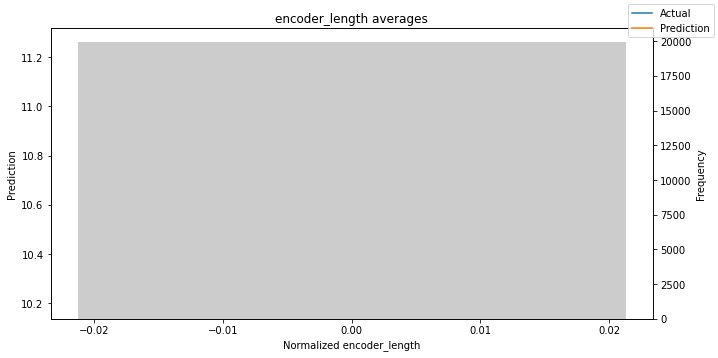

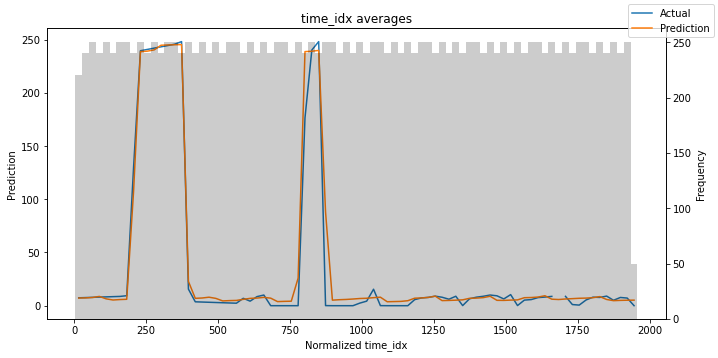

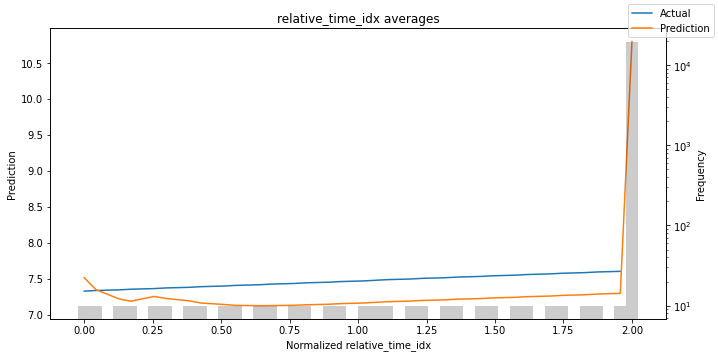

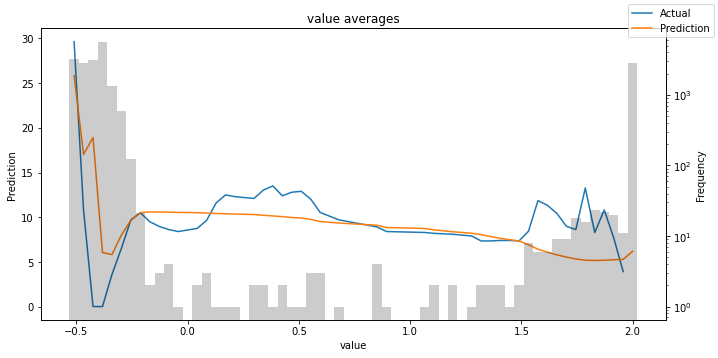

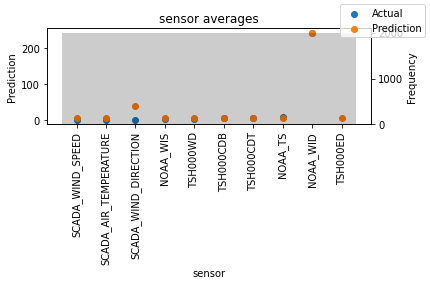

In [5]:
# Plots additional contextual graphs
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

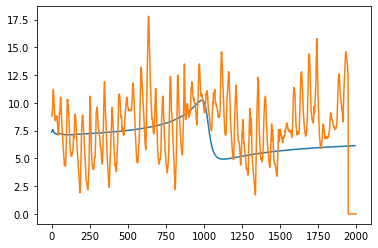

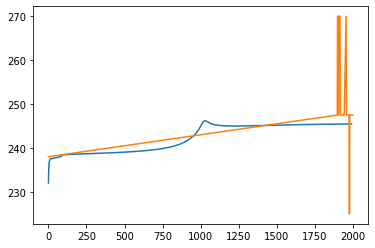

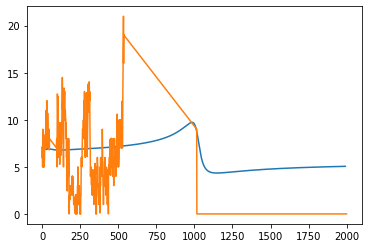

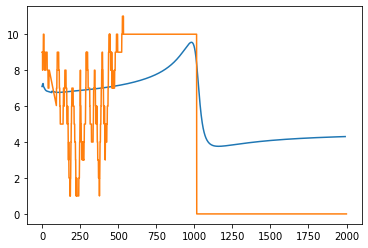

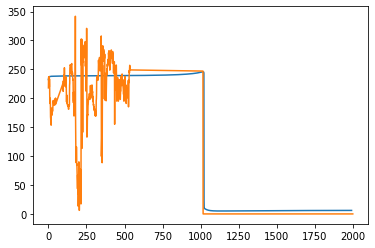

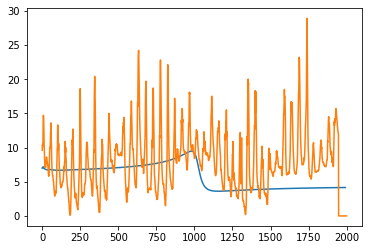

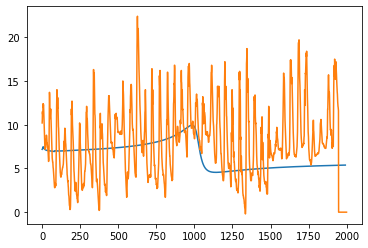

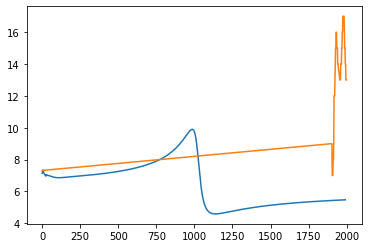

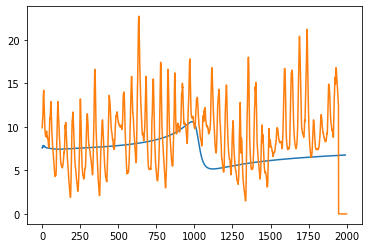

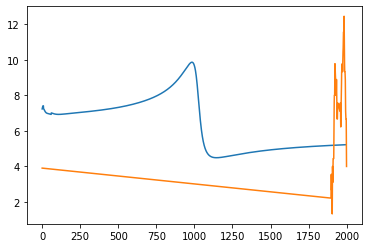

In [6]:
# Gathers predictions and actual values in a format that can be used for anomaly detection
raw_predictions = best_tft.predict(val_dataloader, mode="prediction")
all_preds = []
for i in raw_predictions:
    preds = i.tolist()
    all_preds.append(preds)
all_vals = []
active_sensors = list(active_sensors)
for j in active_sensors:
    vals = ts_data.loc[ts_data["sensor"] == j]
    tmp = []
    for i in vals["value"]:
        tmp.append(i)
    all_vals.append(tmp)

# As the order of predictions doesn't match the order of sensors, runs a quick calculation to match the prediction to its closest value mapping
pred_val_index = []
for i in all_preds:
    min_diff = np.inf
    index = None
    for j in all_vals:
        if abs(sum(i) - sum(j)) < min_diff:
            if all_vals.index(j) not in pred_val_index:
                min_diff = abs(sum(i) - sum(j))
                index = all_vals.index(j)
    pred_val_index.append(index)
all_vals[:] = [all_vals[i] for i in pred_val_index]
active_sensors[:] = [active_sensors[i] for i in pred_val_index]

# Plots the predictions vs actual values only using their raw values
for i in range(len(all_preds)):
    plt.figure()
    plt.plot(all_preds[i])
    plt.plot(all_vals[i])

In [7]:
# Manually input user threshold for anomaly detection
# For instance if the threshold is 100%, an anomaly will be detected when the actual value sits at a 200% increase/decrease
user_threshold = int(input("What is your desired threshold as a percent (i.e.: 150 for a threshold of 150%): "))
user_threshold = user_threshold/100

In [8]:
# Anomaly detection function
# Sets a threshold of 50% if the user has not defined one
if user_threshold == 0 :
    user_threshold = 0.5

# Creates a list of anomalies, where for each of the last 2000 timestamps, if an anomaly has been detected, output 1, else output 0
# Each list of 1/0 anomaly detection is appended to anomaly_list with its related sensor
anomaly_list = []
# For each sensor
for j in range(len(all_preds)):
    anomaly_sensor = []
    # For each value
    for i in range(len(all_preds[j])):
        # If it is above the maximum threshold mark as an anomaly
        if all_preds[j][i]*(1+user_threshold) < all_vals[j][i]:
            anomaly_sensor.append(1)
        # If it is below the minimum threshold mark as an anomaly
        elif all_preds[j][i]*(1-user_threshold) > all_vals[j][i]:
            anomaly_sensor.append(1)
        # Else mark as not an anomaly
        else:
            anomaly_sensor.append(0)
    anomaly_list.append([anomaly_sensor, active_sensors[j]])

In [6]:
import copy
from os import kill
from pathlib import Path
import warnings
import pickle
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pymysql
import psycopg2

def ts_nn(sensitivity = [2,3,4,5,6]):
    # Loads the data from the external database
    dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
    data = pd.read_sql("select * from summary order by timestamp desc limit 2000", dbcon) # Can remove/increase limit if enough GPU memory for CUDA, will increase accuracy
    data.fillna(value = 0, inplace = True) # Replaces NoneType values with 0
    data.replace(1.1e308, 0, inplace = True) # Replaces infinite values with 0
    data = data[::-1]
    data.reset_index(inplace=True, drop=True)

    # Normalizes the data for use in the encoder
    ts_data = pd.DataFrame()
    cols = data.columns[1:]
    sensor = []
    timestamp = []
    value = []
    time_idx = []
    ti = 0
    for i in range(len(data["timestamp"])):
        for j in cols:
            timestamp.append(data["timestamp"][i])
            value.append(data[j][i])
            sensor.append(j)
            time_idx.append(ti)
        ti += 1
    ts_data["timestamp"] = timestamp
    ts_data["sensor"] = sensor
    ts_data["value"] = value
    ts_data["time_idx"] = time_idx
    id = []
    for i in range(len(ts_data)):
        id.append(i)
    ts_data["id"] = id
    # ts_data has 4 columns, timestamp, sensor, value, and time_idx
    # There is a value for each sensor for each timestamp

    # The below optionally removes all sensors which are inactive. This is reccomended to stop overfitting to inactive sensors which causes the predictions to ignore active ones
    # If this is commented out, most predictions will lie at 0 as most sensors have an average value of 0 due to being inactive. Only comment this out if the majority of sensors are active
    tmp = ts_data[ts_data["value"] != 0]
    active_sensors = set(tmp["sensor"])
    ts_data = ts_data[ts_data["sensor"].isin(active_sensors)]

    # This is the only time series function that needs to be ran if you don't want to update the training
    # Creates the data set to run the prediction on using all the most recent data from the external database
    # Sets up the initial parameters
    max_prediction_length = int(len(ts_data)*0.4) # 60% training, 40% testing. Feel free to change this ratio if results are not as expected
    max_encoder_length = 16
    training_cutoff = ts_data["id"].max() - max_prediction_length
    validation = TimeSeriesDataSet(
        ts_data, # No lambda function to select all data
        time_idx="time_idx",
        target="value",
        group_ids=["sensor"], # Required to identify rows uniquely
        min_encoder_length=max_encoder_length//2, 
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        predict_mode=True,
        add_relative_time_idx=True,
        static_categoricals=["sensor"],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["value"],
        allow_missing_timesteps=False # Set to False as time_idx increases steadily, if this function is edited and time_idx no longer increases steadily must be set to True
    )
    # Creates all neccesary functions with the new dataset and best prediction model
    batch_size = 8  # higher values increase accuracy at cost of CUDA memory
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
    torch.cuda.empty_cache()

    # Opens the saved prediction model
    try:
        with open("time-series/ts_model.pkl", "rb") as fout:
            best_tft = pickle.load(fout)
    except:
        print("No model found")
        kill

    # Gathers predictions and actual values in a format that can be used for anomaly detection
    raw_predictions = best_tft.predict(val_dataloader, mode="prediction")
    all_preds = []
    for i in raw_predictions:
        preds = i.tolist()
        all_preds.append(preds)
    all_vals = []
    active_sensors = list(active_sensors)
    for j in active_sensors:
        vals = ts_data.loc[ts_data["sensor"] == j]
        tmp = []
        for i in vals["value"]:
            tmp.append(i)
        all_vals.append(tmp)

    # As the order of predictions doesn't match the order of sensors, runs a quick calculation to match the prediction to its closest value mapping
    pred_val_index = []
    for i in all_preds:
        min_diff = np.inf
        index = None
        for j in all_vals:
            if abs(sum(i) - sum(j)) < min_diff:
                if all_vals.index(j) not in pred_val_index:
                    min_diff = abs(sum(i) - sum(j))
                    index = all_vals.index(j)
        pred_val_index.append(index)
    all_vals[:] = [all_vals[i] for i in pred_val_index]
    active_sensors[:] = [active_sensors[i] for i in pred_val_index]
    sns_ano = []
    for user_threshold in sensitivity:
        # Anomaly detection function
        # Creates a list of anomalies, where for each of the last 2000 timestamps, if an anomaly has been detected, output 1, else output 0
        # Each list of 1/0 anomaly detection is appended to anomaly_list with its related sensor
        anomaly_list = []
        # For each sensor
        for j in range(len(all_preds)):
            anomaly_sensor = []
            # For each value
            for i in range(len(all_preds[j])):
                # If it is above the maximum threshold mark as an anomaly
                if all_preds[j][i]*(np.mean(all_preds[j])+np.std(all_preds[j])*user_threshold) < all_vals[j][i]:
                    anomaly_sensor.append(1)
                # If it is below the minimum threshold mark as an anomaly
                elif all_preds[j][i]*(np.mean(all_preds[j])-np.std(all_preds[j])*user_threshold) > all_vals[j][i]:
                    anomaly_sensor.append(1)
                # Else mark as not an anomaly
                else:
                    anomaly_sensor.append(0)
            anomaly_list.append([anomaly_sensor, active_sensors[j]])
        sns_ano.append([anomaly_list, user_threshold])
    
    return all_preds, all_vals, sns_ano, active_sensors, list(ts_data["timestamp"].unique())

def data_frame(all_preds, all_vals, anomaly_list, active_sensors, timestamps):
    # Sets required outputs up as dataframe to be imported into database
    df = pd.DataFrame()
    sensor = []
    timestamp = []
    value = []
    pred = []
    anomaly = []
    for i in range(len(all_preds[0])):
        for j in active_sensors:
            timestamp.append(timestamps[i])
            value.append(all_vals[active_sensors.index(j)][i])
            pred.append(all_preds[active_sensors.index(j)][i])
            anomaly.append(anomaly_list[active_sensors.index(j)][0][i])
            sensor.append(anomaly_list[active_sensors.index(j)][1])
    df["sensor_id"] = sensor
    df["sensor_time"] = timestamp
    df["value"] = value
    df["pred"] = pred
    df["anomaly"] = anomaly
    # dtb_df is the data pushed to the internal database
    dtb_df = df[df["anomaly"]==1]
    dtb_df = dtb_df[['sensor_time','sensor_id']]
    return df, dtb_df

def push_internal(dtb_df):
    # This adds data to the internal database
    dbcon = psycopg2.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33062)
    cur = dbcon.cursor()
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in dtb_df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(dtb_df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s)" % ("anomalies", cols)
    cur.executemany(query, tuples)
    dbcon.commit()
    cur.close()


all_preds, all_vals, sns_ano, active_sensors, ts_data = ts_nn()
for anomaly_list in sns_ano:
    df, dtb_df = data_frame(all_preds, all_vals, anomaly_list[0], active_sensors, ts_data)
    dtb_df["sensitivity"] = anomaly_list[1]
    push_internal(dtb_df)

KeyboardInterrupt: 